# London clusters

## Business Case:

Companies operating in the tourism sector are interested in suggesting itineraries and destinations tailored to their audience’s interests.

When visiting a city, for example, some travellers may be more interested in visiting museums and art places. Some others may be more interested in a shopping kind of tourism. Some others may be interested in gastronomy, and so on. It is also realistic to think that tourists, when visiting a city, would want to do a mix of things, for example may want to visit art places in the morning, do some shopping in the afternoon, and go out in the evening to some cool night spots area.

Tourism agencies may therefore want to make use of machine learning, and specifically clustering, to provide customers with relevant suggestions as to what areas to go to.


## Data

As a test case, I will try to leverage Foursquare’s data to cluster neighbourhoods in London, United Kingdom. The idea here is to be able to classify each neighbourhood at an overall level in terms of the main attractions it has to offer, and possibly categorise each neighbourhood in main classes, e.g. predominantly ‘shopping area’, or ‘nightlife area’, and so on. (Obviously, some areas have more to offer than only one type of attraction, e.g. there are usually many restaurants around art places. Nevertheless, the clustering should be able to pick on these elements and return clusters which are ‘mixed’. Tourists only interested in food, for example, may still be interested in visiting a ‘mixed’ area which scores very high on ‘food’.)
The analysis will be run by employing the use of the k-means algorithm.

In order to create the cluster, I will build the underlying dataset so that:

•	Each venue category is recoded to its own macro category as per Foursquare category tree (see https://developer.foursquare.com/docs/resources/categories). For example, an Italian restaurant and a Chinese restaurant will be both recoded to their own Macro category ‘Food’. This will allow for the k-means algorithm to work with 9 aggregated macro variable (Food, Travel & Transport, Shop & Service, Arts & Entertainment, Nightlife Spot, Professional & Other Places, Outdoors & Recreation, College & University, Residence) rather than a hundreds of variables (i.e. the venue specific category)

•	Each venue will have its own ‘weight’ in terms of ‘likes’. For each venue, I will retrieve the count of ‘likes’ (i.e. how many people liked the particular venue). This will allow distinguishing between a major and a minor venue (e.g. a relatively unknown music venue ‘The Blue Studios’ has 6 likes, whereas an important music venue ‘The O2 Arena’ has 3154 likes) rather treating all venues as equal.

As for the geographical units to take into consideration, I have opted for the rail stations (overground and underground) in London zones 1, 2 and 3 (the central zones) as they are evenly spread across the city, whereas the actual administrative units (London boroughs) vary quite dramatically in terms of size amongst themselves.


## Methodology

In this section I will carry out the data processing and analysis. 

As briefly explained above I will look at the target geographical areas (underground and overground stations in London zones 1, 2, and 3) and extract their 'essence' as a whole by grouping together the venue types under few macro categories, and weight the dataset by the number of venue 'likes'.

I will then explore the resulting dataset by looking at the correlation between macro categories and get some extra insight by creating a dendrogram (although I will not be running a hierarchical clustering).  

I will finally proceed with the clustering of the London stations via the k-means algorithm by applying the optimal number of cluster as suggested by the analysis of the sum of square distances ('elbow method').  

---------------------------------------------

Methodology overview - in the next paragraphs:

<i>Stations:</i><br>
1.1   retrieve the stations list and their coordinates coordinates.<br>
1.2   chart the stations <br>

<i>Foursquare data:</i><br>
2.1   build a Foursquare category look-up table. With this table I will be able to say what micro-category translate into what macro category (e.g. a pizza place and a burrito restaurant will both fall in the 'Food' macro category) <br>
2.2   for each station, gather the venues in a radius of 1000 meters. In this loop, alongside with collecting the venue info (e.g. name, category,...), I will also calculate the distance from the venue and the station, together with retrieving the venue macro category via the look-up table above.<br>
2.3   for each venue, retrieve the number of 'likes'. In here I will loop through all the unique venues collected (10,000+) and collect their number of 'likes' given by Foursquare users.<br>
2.4   build a dataframe in which each venue row is repetead a 'Likes' number of times (e.g. if venue X has 3 likes, venue X will be repeated 3 times). This dataframe will be used in the one-hot encoding method to account for the number of likes for the clustering.   

<i>Preliminary analysis:</i><br>
3.1   correlation between macro categories<br>
3.2   looking at venue groups via dendrogram<br>

<i>Clustering with k-means:</i><br>
4.1   look for the optimal k (via elbow method)<br>
4.2   clustering with k-means algorithm<br>
4.3   cluster interpretation<br>
4.4   chart of clusters<br>
    

#### Methodology - Stations

Retrieve the stations coordinates using beautiful soup:

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

res = requests.get("https://www.doogal.co.uk/london_stations.php")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))
df = df[0]
print(df.shape)
df.head()

(641, 7)


,Station,Zone,Postcode,Latitude,Longitude,Easting,Northing
0,Abbey Road,3.0,E15 3NB,51.531952,0.003738,539081,183352
1,Abbey Wood,4.0,SE2 9RH,51.490784,0.120286,547297,179002
2,Acton Central,2.0,W3 6BH,51.508758,-0.263416,520613,180299
3,Acton Main Line,3.0,W3 9EH,51.516887,-0.267676,520296,181196
4,Acton Town,3.0,W3 8HN,51.503071,-0.280288,519457,179639


The query returned 641 stations. For ease of computation, let's now filter for the ones in zones 1, 2 and 3 only. These are the main areas where tourists are likely to visit. 

In [2]:
stations = df.loc[df['Zone'].isin(['1','2', '12', '3', '23', '34'])]
print(stations.shape)
stations.head()

(340, 7)


,Station,Zone,Postcode,Latitude,Longitude,Easting,Northing
0,Abbey Road,3.0,E15 3NB,51.531952,0.003738,539081,183352
2,Acton Central,2.0,W3 6BH,51.508758,-0.263416,520613,180299
3,Acton Main Line,3.0,W3 9EH,51.516887,-0.267676,520296,181196
4,Acton Town,3.0,W3 8HN,51.503071,-0.280288,519457,179639
8,Aldgate,1.0,EC3N 1AH,51.514342,-0.075613,533629,181246


We ended up with 340 stations. Chart them:

In [4]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map of London Stations using latitude and longitude values
map_stations = folium.Map(location=[51.49787, -0.04967], zoom_start=11)

# add markers to map
for lat, lng, label in zip(stations['Latitude'], stations['Longitude'], stations['Station']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(map_stations)  
    
map_stations

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.3.9   |       hecc5488_0         146 KB  conda-forge
    altair-2.2.2               |           py35_1         462 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.0 MB

The following NEW packages will

#### Methodology - Foursquare data

2.1 Create the look up table:

In [5]:
# The code was removed by Watson Studio for sharing.

In [6]:
#Create Foursquare Parent Category Table
import requests
import json
url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION)
#print(url)
resp = requests.get(url).json()
data = resp['response']

# the following function is to look into each leave of the category tree (see: https://developer.foursquare.com/docs/resources/categories) 
# from the request above and retrieve 1) the macro category id, 2) the macro category name, and 3) the micro category id. 
# These 3 values will be passed to a list ('myList') 
myList = []
def print_dict(v, prefix=''):
    
    if isinstance(v, dict):
        for k, v2 in v.items():
            p2 = "{}['{}']".format(prefix, k)
            print_dict(v2, p2)
    elif isinstance(v, list):
        for i, v2 in enumerate(v):
            p2 = "{}[{}]".format(prefix, i)
            print_dict(v2, p2)
    else:
        if 'id' in prefix:
            curr_category_id = v
            root_category_index = int(prefix[15]) # position 15 of prefix holds parent category from 0 to 9
            root_category_id = data['categories'][root_category_index]['id']
            root_category_name = data['categories'][root_category_index]['name']
            myList.extend([root_category_id, curr_category_id, root_category_name])

print_dict(data)

# Use a function (chunks) to split the list created above by 3 items and putting the sub-lists in a dataframe.
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

myCatTable = pd.DataFrame(chunks(myList, 3))

myCatTable.head()

,0,1,2
0,4d4b7104d754a06370d81259,56aa371be4b08b9a8d5734db,Arts & Entertainment
1,4d4b7104d754a06370d81259,4fceea171983d5d06c3e9823,Arts & Entertainment
2,4d4b7104d754a06370d81259,4bf58dd8d48988d1e1931735,Arts & Entertainment
3,4d4b7104d754a06370d81259,4bf58dd8d48988d1e2931735,Arts & Entertainment
4,4d4b7104d754a06370d81259,4bf58dd8d48988d1e4931735,Arts & Entertainment


I now have my look-up table: for each venue category (column 1) I know its macro category. E.g. venue category id 56aa371be4b08b9a8d5734db ('Amphitheater') is now associated with its macro category id 4d4b7104d754a06370d81259 ('Arts & Entertainment'). Visit https://developer.foursquare.com/docs/resources/categories for a better understanding.

Now I proceed with getting the venue info for each station. Note that when running the for loop, I also calculate the distance between the venue and the station (euclidian distance between venue coordinates and station coordinates - I will use this to deduplicate venues later on), and retrieve the venue macro category by looking up the micro category value in the table created  above:

In [42]:
# 1. Get Foursquare venues
import requests
import json
import math


# 3. Get the venue info from Foursquare
radius = 1000
LIMIT = 300
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    i = 1
    
    venues_list=[]
    #file = open('myStations.csv','a')
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        #print(i, name)
        i = i + 1
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            math.sqrt((v['venue']['location']['lat']-lat)**2 + (v['venue']['location']['lng']-lng)**2), #calculate distance btw station and venue
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['id'],
            myCatTable.loc[myCatTable[1] == v['venue']['categories'][0]['id'], 2].item()) for v in results]) # grab the macro category value from look up table
        
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude', 
                             'Venue Name',
                             'Venue ID',
                             'Venue Latitude', 
                             'Venue Longitude',
                             'Venue Distance from Neigh',
                             'Venue Category',
                             'Venue Category ID', 
                             'Macro Category Name']
    
    #file.close()
    return(nearby_venues)

london_venues = getNearbyVenues(names=stations['Station'],
                                latitudes=stations['Latitude'],
                                longitudes=stations['Longitude'])

london_venues.to_csv('stations.csv', mode='a', header=True, index=False)

print(london_venues.shape)
london_venues.head()


(14134, 11)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue ID,Venue Latitude,Venue Longitude,Venue Distance from Neigh,Venue Category,Venue Category ID,Macro Category Name
0,Abbey Road,51.531952,0.003738,The Greenway,4e0ef23022711665f619a691,51.530350,0.001172,0.003025,Trail,4bf58dd8d48988d159941735,Outdoors & Recreation
1,Abbey Road,51.531952,0.003738,Rial Lifestyle Café,4bafbc5bf964a5205f1c3ce3,51.527761,0.005202,0.004439,Café,4bf58dd8d48988d16d941735,Food
2,Abbey Road,51.531952,0.003738,Stratford Depot Staff Halt,4dcc4270d164ef21c4b7db03,51.533036,0.001917,0.002119,Platform,4f4531504b9074f6e4fb0102,Travel & Transport
3,Abbey Road,51.531952,0.003738,Abbey Mills Pumping Station,4bf524716a31d13a337c962e,51.530780,-0.001491,0.005359,Historic Site,4deefb944765f83613cdba6e,Arts & Entertainment
4,Abbey Road,51.531952,0.003738,Platform 1,4de267051fc7ca155a6e0c3b,51.528684,0.005840,0.003885,Platform,4f4531504b9074f6e4fb0102,Travel & Transport


The London venues dataset contains in excess of 14000 venues. Note that each venue category has been recoded to its macro category (see last column). 

Now, I check if there are duplicates - the same venue may have been picked up in different queries. Check for duplicates, e.g. venue '5c66c388947c05003948a783'

In [39]:
london_venues.loc[london_venues['Venue ID'] == '5c66c388947c05003948a783']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue ID,Venue Latitude,Venue Longitude,Venue Distance from Neigh,Venue Category,Venue Category ID,Macro Category Name
150,Aldgate,51.514342,-0.075613,The Garden at 120,5c66c388947c05003948a783,51.512101,-0.080799,0.005649,Garden,4bf58dd8d48988d15a941735,Outdoors & Recreation
4554,Fenchurch Street,51.511567,-0.078540,The Garden at 120,5c66c388947c05003948a783,51.512101,-0.080799,0.002321,Garden,4bf58dd8d48988d15a941735,Outdoors & Recreation
8678,Monument,51.510630,-0.086174,The Garden at 120,5c66c388947c05003948a783,51.512101,-0.080799,0.005573,Garden,4bf58dd8d48988d15a941735,Outdoors & Recreation
12369,Tower Gateway,51.510393,-0.074395,The Garden at 120,5c66c388947c05003948a783,51.512101,-0.080799,0.006628,Garden,4bf58dd8d48988d15a941735,Outdoors & Recreation
12433,Tower Hill,51.510394,-0.076687,The Garden at 120,5c66c388947c05003948a783,51.512101,-0.080799,0.004452,Garden,4bf58dd8d48988d15a941735,Outdoors & Recreation


Yes there are duplicates (the same venue has been picked by different queries). Deduplicate the dataframe only keeping one venue - the one with the shortest distance from its station:

In [43]:
# sort the df:
london_venues.sort_values(by =['Venue ID' , 'Venue Distance from Neigh'], inplace = True)

# drop duplicates but keep the first one:
london_venues.drop_duplicates(subset = 'Venue ID', keep = 'first', inplace = True)

# create a csv file - deduplicated venues
london_venues.to_csv('london_venues.csv', mode='a', header=True, index=False)

# see the results:
london_venues.shape

(10134, 11)

The df now contains about 10000 rows. Check there are no duplicates:

In [44]:
london_venues.loc[london_venues['Venue ID'] == '5c66c388947c05003948a783']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue ID,Venue Latitude,Venue Longitude,Venue Distance from Neigh,Venue Category,Venue Category ID,Macro Category Name
4554,Fenchurch Street,51.511567,-0.07854,The Garden at 120,5c66c388947c05003948a783,51.512101,-0.080799,0.002321,Garden,4bf58dd8d48988d15a941735,Outdoors & Recreation


Prepare the dataset to host the 'Likes' information: I add a new column 'Likes' and populate it with value 'TBI' ('To Be Inserted' - this value will be used later on):

In [46]:
import pandas as pd
xdf = pd.read_csv("london_venues.csv") # read stations_venues.csv into a pandas df
xdf['Likes'] = 'TBI' # add a colummn and populate it with 'TBI' - to be inserted
xdf.to_csv('stations_venues_work.csv', mode='w', header=True, index=False) # create new csv file

Now loop trough all venues and query the 'like' argument:

In [66]:
df = pd.read_csv("stations_venues_work.csv")
for i in range(10134): #10134 venues to go through
    if str(df.iloc[i,11]) == 'TBI':
        venue_id = df.iloc[i,4]
        url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        try:
            ratingSignal = result['response']['likes']['count'] # get the Likes value
        except:
            ratingSignal = 0
        df.iloc[i,11] = ratingSignal # insert new value in DF
        df.to_csv('stations_venues_work.csv', mode='w', header=True, index=False) #overwrite entire file

In [70]:
# output result df
df = pd.read_csv("stations_venues_work.csv")
print(df.shape)
df.head()

(10134, 12)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue ID,Venue Latitude,Venue Longitude,Venue Distance from Neigh,Venue Category,Venue Category ID,Macro Category Name,Likes
0,Gloucester Road,51.494500,-0.183529,Byron,4a5f9446f964a520e0bf1fe3,51.494793,-0.182468,0.001101,Burger Joint,4bf58dd8d48988d16c941735,Food,193
1,Piccadilly Circus,51.509697,-0.133697,Haymarket Hotel,4abcec53f964a520b98720e3,51.508267,-0.131315,0.002779,Hotel,4bf58dd8d48988d1fa931735,Travel & Transport,47
2,Tottenham Court Road,51.516211,-0.131096,Patara,4abe5714f964a520d68c20e3,51.514136,-0.130855,0.002089,Thai Restaurant,4bf58dd8d48988d149941735,Food,151
3,Knightsbridge,51.501355,-0.160650,Harrods,4abf8c03f964a520079120e3,51.499572,-0.162698,0.002715,Department Store,4bf58dd8d48988d1f6941735,Shop & Service,10475
4,Hyde Park Corner,51.502584,-0.152460,The Athenaeum‬‪‬‪‬ Hotel,4ac51183f964a52045a020e3,51.504589,-0.147353,0.005486,Hotel,4bf58dd8d48988d1fa931735,Travel & Transport,115


we now have, for each entry its 'Likes' value (see the last column in the df above). The number of Likes gives us an indication of the importance of a place.

Now build a df with each entry repeated its number of Likes (e.g. an entry with 3 likes will be repeated 3 times):

In [72]:
# VERY HEAVY DO NOT RUN
import pandas as pd
import numpy as np
df1 = pd.read_csv("stations_venues_work.csv")
df2 = pd.DataFrame(columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude',
       'Venue Name', 'Venue ID', 'Venue Latitude', 'Venue Longitude',
       'Venue Distance from Neigh', 'Venue Category', 'Venue Category ID',
       'Macro Category Name', 'Likes'])

i = 0
for t in df1['Neighborhood']:
    numtimes = df1.iloc[i,11] + 1
    myZ = pd.DataFrame(df1.loc[i:i]) 
    newdf = pd.DataFrame(np.repeat(myZ.values,numtimes,axis=0))
    newdf.columns = df2.columns
    df2 = df2.append(newdf, ignore_index=True)
    i = i + 1

df2.to_csv('stations_venues_repetitions.csv', mode='w', header=True, index=False)

#### Methodology - preliminary analysis

In [34]:
# The code was removed by Watson Studio for sharing.

In [35]:
# The code was removed by Watson Studio for sharing.

In [36]:
import pandas as pd
import numpy as np
df1 = stations_venues_no_repetitions
df2 = pd.DataFrame(columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude',
       'Venue Name', 'Venue ID', 'Venue Latitude', 'Venue Longitude',
       'Venue Distance from Neigh', 'Venue Category', 'Venue Category ID',
       'Macro Category Name', 'Likes'])

i = 0
for t in df1['Neighborhood']:
    numtimes = df1.iloc[i,11]
    myZ = pd.DataFrame(df1.loc[i:i]) 
    newdf = pd.DataFrame(np.repeat(myZ.values,numtimes,axis=0))
    newdf.columns = df2.columns
    df2 = df2.append(newdf, ignore_index=True)
    i = i + 1

project.save_data(data=df2.to_csv(index=False),file_name='stations_venues_repetitions.csv',overwrite=True)

{'asset_id': '3492476a-db70-4462-adac-57ea32f7b55f',
 'bucket_name': 'courseraapplieddatasciencecapston-donotdelete-pr-4xv7mn7x8d1blt',
 'file_name': 'stations_venues_repetitions.csv',
 'message': 'File saved to project storage.'}

In [2]:
# The code was removed by Watson Studio for sharing.

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue ID,Venue Latitude,Venue Longitude,Venue Distance from Neigh,Venue Category,Venue Category ID,Macro Category Name,Likes
0,Gloucester Road,51.4945,-0.183529,Byron,4a5f9446f964a520e0bf1fe3,51.494793,-0.182468,0.001101,Burger Joint,4bf58dd8d48988d16c941735,Food,193
1,Gloucester Road,51.4945,-0.183529,Byron,4a5f9446f964a520e0bf1fe3,51.494793,-0.182468,0.001101,Burger Joint,4bf58dd8d48988d16c941735,Food,193
2,Gloucester Road,51.4945,-0.183529,Byron,4a5f9446f964a520e0bf1fe3,51.494793,-0.182468,0.001101,Burger Joint,4bf58dd8d48988d16c941735,Food,193
3,Gloucester Road,51.4945,-0.183529,Byron,4a5f9446f964a520e0bf1fe3,51.494793,-0.182468,0.001101,Burger Joint,4bf58dd8d48988d16c941735,Food,193
4,Gloucester Road,51.4945,-0.183529,Byron,4a5f9446f964a520e0bf1fe3,51.494793,-0.182468,0.001101,Burger Joint,4bf58dd8d48988d16c941735,Food,193


I have now created a dataset with repetitions - the likes are the number of rows repeated in the dataset.

I will now proceed with the one-hot encoding on the macro category: I want to transform this variable in numerical dummies so to explore the data structure and eventually perform the clustering. 



In [3]:
import pandas as pd
import numpy as np
london_venues = stations_venues_repetition


# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Macro Category Name']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Neighborhood'] = london_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

,Neighborhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Gloucester Road,0,0,1,0,0,0,0,0,0
1,Gloucester Road,0,0,1,0,0,0,0,0,0
2,Gloucester Road,0,0,1,0,0,0,0,0,0
3,Gloucester Road,0,0,1,0,0,0,0,0,0
4,Gloucester Road,0,0,1,0,0,0,0,0,0


With the one-hot encdong the Macro category has been split in 9 dummies. Let's have a look at how these newly created variables correlate:

In [4]:
import pandas as pd
import numpy as np

df = london_onehot.groupby(['Neighborhood']).sum()
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r' & 'BrBG' are other good diverging colormaps

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
Arts & Entertainment,1,-0.00235511,0.375284,0.237124,0.18775,0.0821877,-0.0147167,0.126498,0.103806
College & University,-0.00235511,1,0.0326766,0.0415591,-0.0128941,-0.00125825,-0.00668414,-0.00870741,0.012155
Food,0.375284,0.0326766,1,0.63891,0.380545,0.0740216,0.046342,0.735733,0.487547
Nightlife Spot,0.237124,0.0415591,0.63891,1,0.29441,0.110444,0.0324091,0.385691,0.298087
Outdoors & Recreation,0.18775,-0.0128941,0.380545,0.29441,1,0.094505,-0.0112021,0.285808,0.235801
Professional & Other Places,0.0821877,-0.00125825,0.0740216,0.110444,0.094505,1,-0.00581219,0.0375124,0.0958777
Residence,-0.0147167,-0.00668414,0.046342,0.0324091,-0.0112021,-0.00581219,1,-0.00196117,0.123419
Shop & Service,0.126498,-0.00870741,0.735733,0.385691,0.285808,0.0375124,-0.00196117,1,0.29212
Travel & Transport,0.103806,0.012155,0.487547,0.298087,0.235801,0.0958777,0.123419,0.29212,1


From the table above shows an overall low correlation between variables. I could interpret this as every variable pulling in its own direction (which is good news for the purpose of clustering). However, also note that Food correlates mildly strongly with Nightlife and Shop & Services. This makes sense intuitively. 

Now, let's explore what the data looks like with a dendogram:

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:44: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


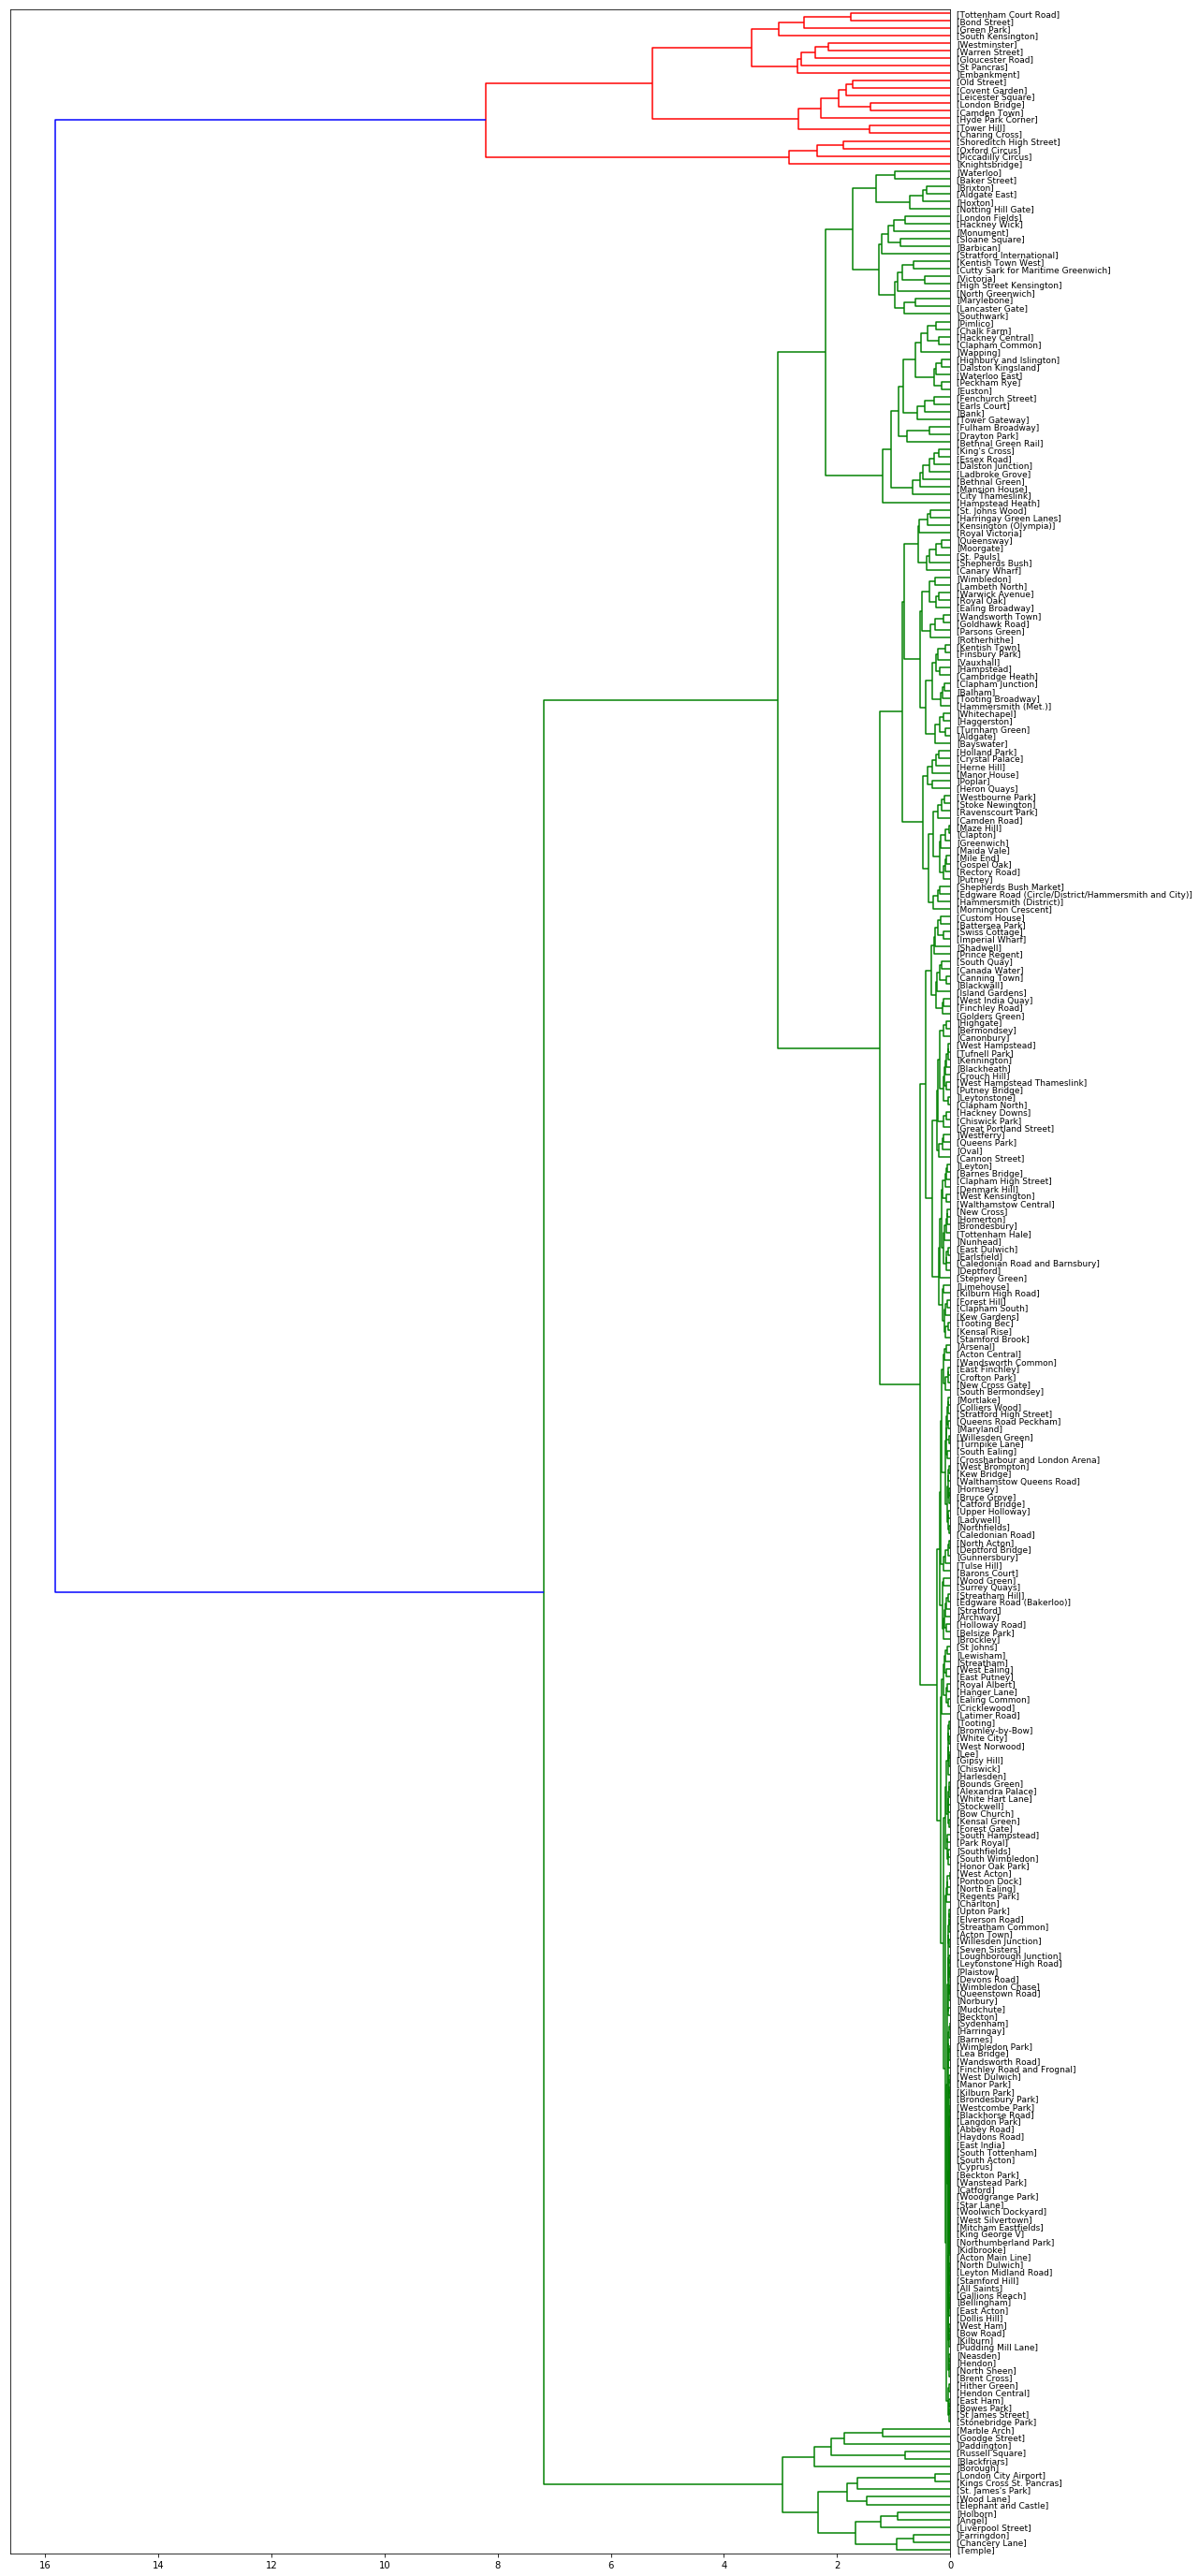

In [10]:
# prepare the df
dfC = london_onehot.groupby(['Neighborhood']).sum()
dfC.dropna()
dfC.reset_index(inplace = True)


import numpy as np 
import pandas as pd
from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from matplotlib import pyplot as plt 
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering 
from sklearn.datasets.samples_generator import make_blobs 
%matplotlib inline



featureset = dfC[['Arts & Entertainment',  'College & University', 'Food', 'Nightlife Spot', 
                  'Outdoors & Recreation', 'Professional & Other Places', 'Residence', 
                  'Shop & Service', 'Travel & Transport']]

# NORMALISATION
from sklearn.preprocessing import MinMaxScaler

x = featureset.values #returns a numpy array
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)

# CLUSTERING USING scipy
# first, calculate the distance matrix
import scipy
leng = feature_mtx.shape[0]
D = scipy.zeros([leng,leng])
for i in range(leng):
    for j in range(leng):
        D[i,j] = scipy.spatial.distance.euclidean(feature_mtx[i], feature_mtx[j])

# In agglomerative clustering, at each iteration, the algorithm must update the distance matrix to reflect the distance of the newly formed cluster with the remaining clusters in the forest. The following methods are supported in Scipy for calculating the distance between the newly formed cluster and each:
# We use complete for our case, but feel free to change it to see how the results change.
import pylab
import scipy.cluster.hierarchy
Z = hierarchy.linkage(D, 'average')


#from scipy.cluster.hierarchy import fcluster
#k = 5
#clusters = fcluster(Z, k, criterion='maxclust')
#print(clusters)


fig = pylab.figure(figsize=(18,50))
def llf(id):
    return '[%s]' % (dfC['Neighborhood'][id] )
    
dendro = hierarchy.dendrogram(Z,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =9, orientation = 'left')


In [ ]:
The dendogram above highlights the difference in 2 main groups of stations / neighborohoods. Looking at the labels I can 

### Clustering using k-means

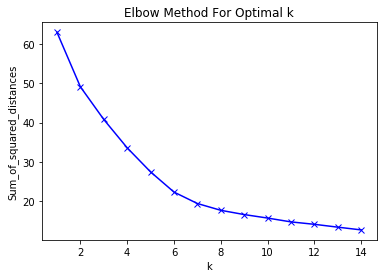

In [14]:

london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index()
london_grouped_clustering = london_grouped.drop('Neighborhood', 1)

# import k-means from clustering stage
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(london_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    
    
# Import required packages
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The elbow method suggests the optimal number of clusters I should be using is 6. I will apply this to the k-mean clustering: 

In [15]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 6

#london_grouped_clustering = london_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

# add clustering labels to london
london_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [19]:

stations.rename(columns={'Station':'Neighborhood'}, inplace = True)
stations.head()

london_merged = stations

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
london_merged = london_merged.join(london_grouped.set_index('Neighborhood'), on='Neighborhood')
#london_merged['Cluster Labels'] = london_merged['Cluster Labels'].astype(int)
london_merged.dropna(subset=['Cluster Labels'], inplace = True)
london_merged['Cluster Labels'] = london_merged['Cluster Labels'].astype(int)
london_merged.to_csv('stations_london_merged.csv', mode='w', header=True, index=False)
london_merged.head() # check the last columns!

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Neighborhood,Zone,Postcode,Latitude,Longitude,Easting,Northing,Cluster Labels,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Abbey Road,3.0,E15 3NB,51.531952,0.003738,539081,183352,2,0.166667,0.0,0.000000,0.000000,0.777778,0.0,0.0,0.000000,0.055556
2,Acton Central,2.0,W3 6BH,51.508758,-0.263416,520613,180299,2,0.024561,0.0,0.115789,0.329825,0.449123,0.0,0.0,0.042105,0.038596
3,Acton Main Line,3.0,W3 9EH,51.516887,-0.267676,520296,181196,2,0.000000,0.0,0.000000,0.000000,0.428571,0.0,0.0,0.285714,0.285714
4,Acton Town,3.0,W3 8HN,51.503071,-0.280288,519457,179639,5,0.282828,0.0,0.606061,0.000000,0.000000,0.0,0.0,0.000000,0.111111
8,Aldgate,1.0,EC3N 1AH,51.514342,-0.075613,533629,181246,5,0.000000,0.0,0.748711,0.167526,0.015034,0.0,0.0,0.003866,0.064863


In [20]:
london_grouped.groupby('Cluster Labels').mean()
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
s = london_grouped.groupby('Cluster Labels').mean().style.background_gradient(cmap=cm)
s

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
Cluster Labels,,,,,,,,,
0,0.0536797,0.000159012,0.24046,0.496934,0.0639649,0.0116497,0,0.0770291,0.0561241
1,0.0566454,0,0.244842,0.070776,0.0589283,0.0141956,0,0.497122,0.0574907
2,0.024453,0,0.151738,0.0724089,0.568078,0.00551639,0,0.0986991,0.0791072
3,0.028984,0,0.217085,0.0994214,0.0708042,0,0,0.0268797,0.556825
4,0.435881,7.36864e-06,0.261052,0.121039,0.0622205,0.0264479,0,0.0515838,0.0417674
5,0.0366682,6.93962e-05,0.58769,0.17004,0.0639494,0.00562778,7.67016e-05,0.087067,0.0488116


In the table above we can see the 6 clusters created and their strenghts:
    1 
    2
    3
    4
    5
    6
    
Here below I perform a count on the clusters:

In [21]:
london_grouped.groupby('Cluster Labels').count()

,Neighborhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
Cluster Labels,,,,,,,,,,
0,58,58,58,58,58,58,58,58,58,58
1,42,42,42,42,42,42,42,42,42,42
2,29,29,29,29,29,29,29,29,29,29
3,19,19,19,19,19,19,19,19,19,19
4,34,34,34,34,34,34,34,34,34,34
5,156,156,156,156,156,156,156,156,156,156


Finally, here are the results charted:

In [24]:
#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library


# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

# create map
map_clusters = folium.Map(location=[51.5074, 0.1278], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Neighborhood'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-2.2.2               |           py35_1         462 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ca-certificates-2019.3.9   |       hecc5488_0         146 KB  conda-forge
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.0 MB

The following NEW packages will